6.Jupyter Notebook

# Housing Price Analysis 

source - http://www.amstat.org/publications/jse/v19n3/decock.pdf

A homebuyer asked to describe their dream house will not begin with talking about the height of the ceiling , car score or proximity to a metro. There are so many more factors that influences price negotiations . This data set has 79 explanatory variables describing every aspect of residential homes in Ames,Iowa which will be used to predict factors influencing house prices.

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

Import Data set and cleansing 

In [36]:
housingData_train = pd.read_csv("train.csv")
housingData_test = pd.read_csv("test.csv")

In [37]:
housingData_test.head()
housingData_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Missing Data & Cleansing

In [38]:
housingNa = housingData_train.isnull().sum()
housingNa = housingNa.sort_values(ascending=False)

 List number of null values in each feature

In [39]:
print (format(housingNa))

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

In [40]:
#missing data as a percentage
percent = 100 * (housingData_train.isnull().sum()/housingData_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([housingNa, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that we should delete. The point is: will we miss this data? I don't think so. None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house (maybe that's the reason why data is missing?). Moreover, looking closer at the variables, we could say that variables like 'PoolQC', 'MiscFeature' and 'FireplaceQu' are strong candidates for outliers, so we'll be happy to delete them.
For 'GarageX' we see that the number of missing variables are the same. These variables look irrelevant to us and we will not consider them
Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential.
Finally, we have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.

In [41]:
#we'll delete all the variables with missing data, except the variable 'Electrical'. 
#In 'Electrical' we'll just delete the observation with missing data.
housingData_train = housingData_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
housingData_train = housingData_train.drop(housingData_train.loc[housingData_train['Electrical'].isnull()].index)


In [42]:
#check for missing data
housingData_train.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
ExterQual        0
ExterCond        0
Foundation       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
                ..
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
GarageCars       0
GarageArea       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch   

Outliers

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


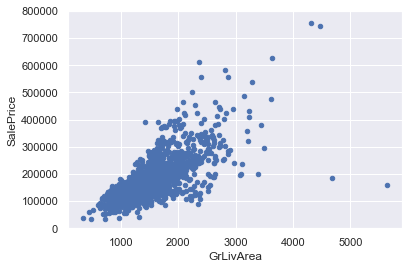

In [43]:
#bivariate analysis saleprice/grlivarea
data = pd.concat([housingData_train['SalePrice'], housingData_train['GrLivArea']],axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))

1.There are 2 values with high 'GrLivArea' and they do not have a higher 'SalesPrice'. We are unable to explain the low price . They do not represent a typical case and we can define them as outliers.
2.There are a few outliers on top which have a higher price , they do however seem to be following a trend and will keep them as they could be special cases.

In [44]:
#Removing outliers
housingData_train.sort_values(by = 'GrLivArea' , ascending = False)[:2]
housingData_train= housingData_train.drop(housingData_train[housingData_train['Id']== 1299].index)
housingData_train= housingData_train.drop(housingData_train[housingData_train['Id']== 524].index)



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


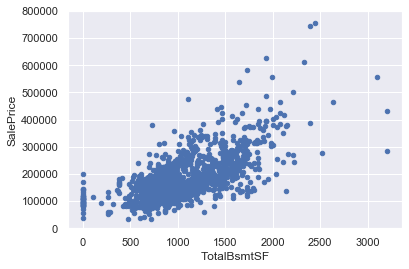

In [45]:
#bivariate analysis saleprice/totbsmtsf
data = pd.concat([housingData_train['SalePrice'], housingData_train['TotalBsmtSF']],axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000))

Although there are outliers we should be Ok with them since they are not too far away from the trend

In [46]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(housingData_train.shape))
print("The test data size before dropping Id feature is : {} ".format(housingData_test.shape))

#Save the 'Id' column
train_ID = housingData_train['Id']
test_ID = housingData_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
housingData_train.drop("Id", axis = 1, inplace = True)
housingData_test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("The train data size before dropping Id feature is : {} ".format(housingData_train.shape))
print("The test data size before dropping Id feature is : {} ".format(housingData_test.shape))


The train data size before dropping Id feature is : (1457, 63) 
The test data size before dropping Id feature is : (1459, 80) 
The train data size before dropping Id feature is : (1457, 62) 
The test data size before dropping Id feature is : (1459, 79) 


Analysing 'SalePrice' since this is our target variable

In [47]:
housingData_train['SalePrice'].describe()

count      1457.000000
mean     180942.138641
std       79521.569966
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

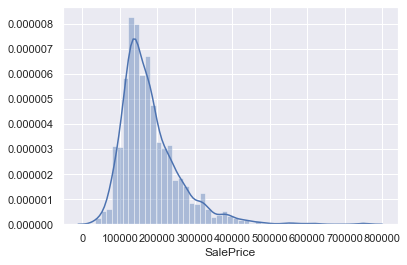

In [48]:
sns.distplot(housingData_train['SalePrice'])

Relationship of Numerical values with SalePrice

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


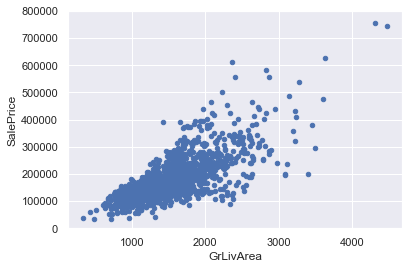

In [49]:
#GrLivArea
data = pd.concat([housingData_train['SalePrice'], housingData_train['GrLivArea']],axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


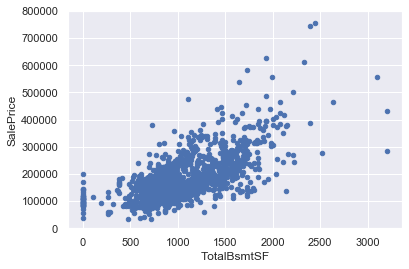

In [50]:
#TotalBsmtSF
data = pd.concat([housingData_train['SalePrice'], housingData_train['TotalBsmtSF']],axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000))

Relationship with categorical features

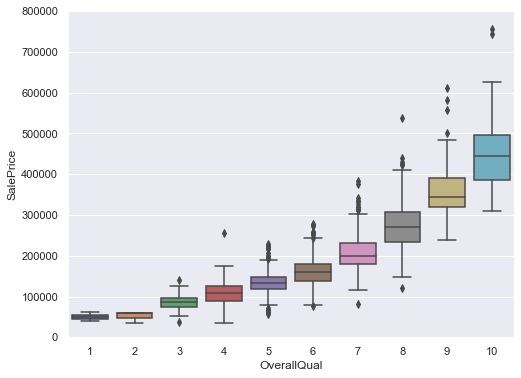

In [51]:
#box plot overallqual/saleprice
data = pd.concat([housingData_train['SalePrice'], housingData_train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

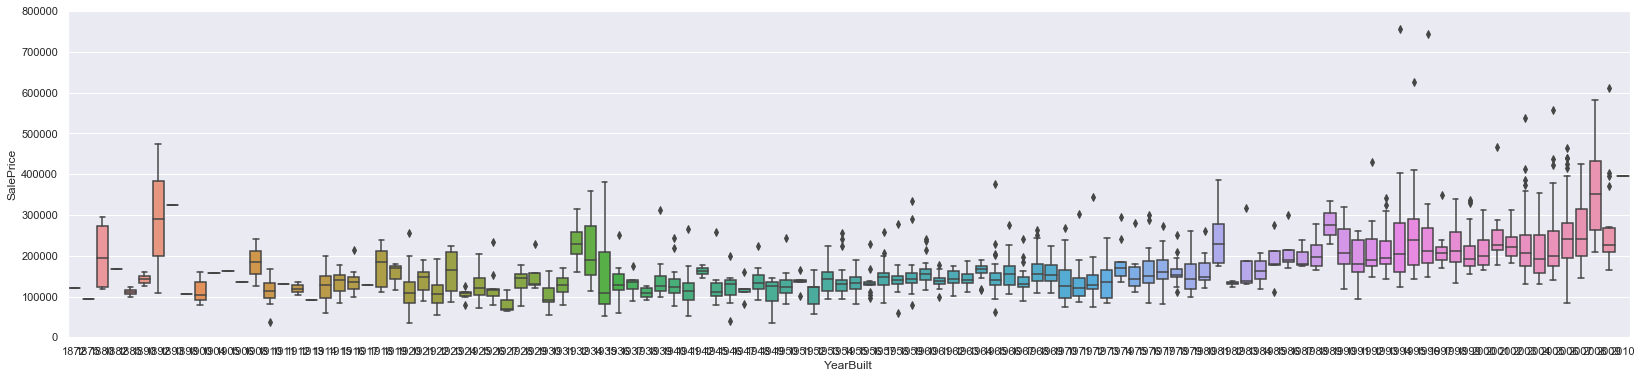

In [52]:
#YearBuilt
data = pd.concat([housingData_train['SalePrice'], housingData_train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(28, 6))
fig = sns.boxplot(x='YearBuilt', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

'GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.
'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.

Correlation

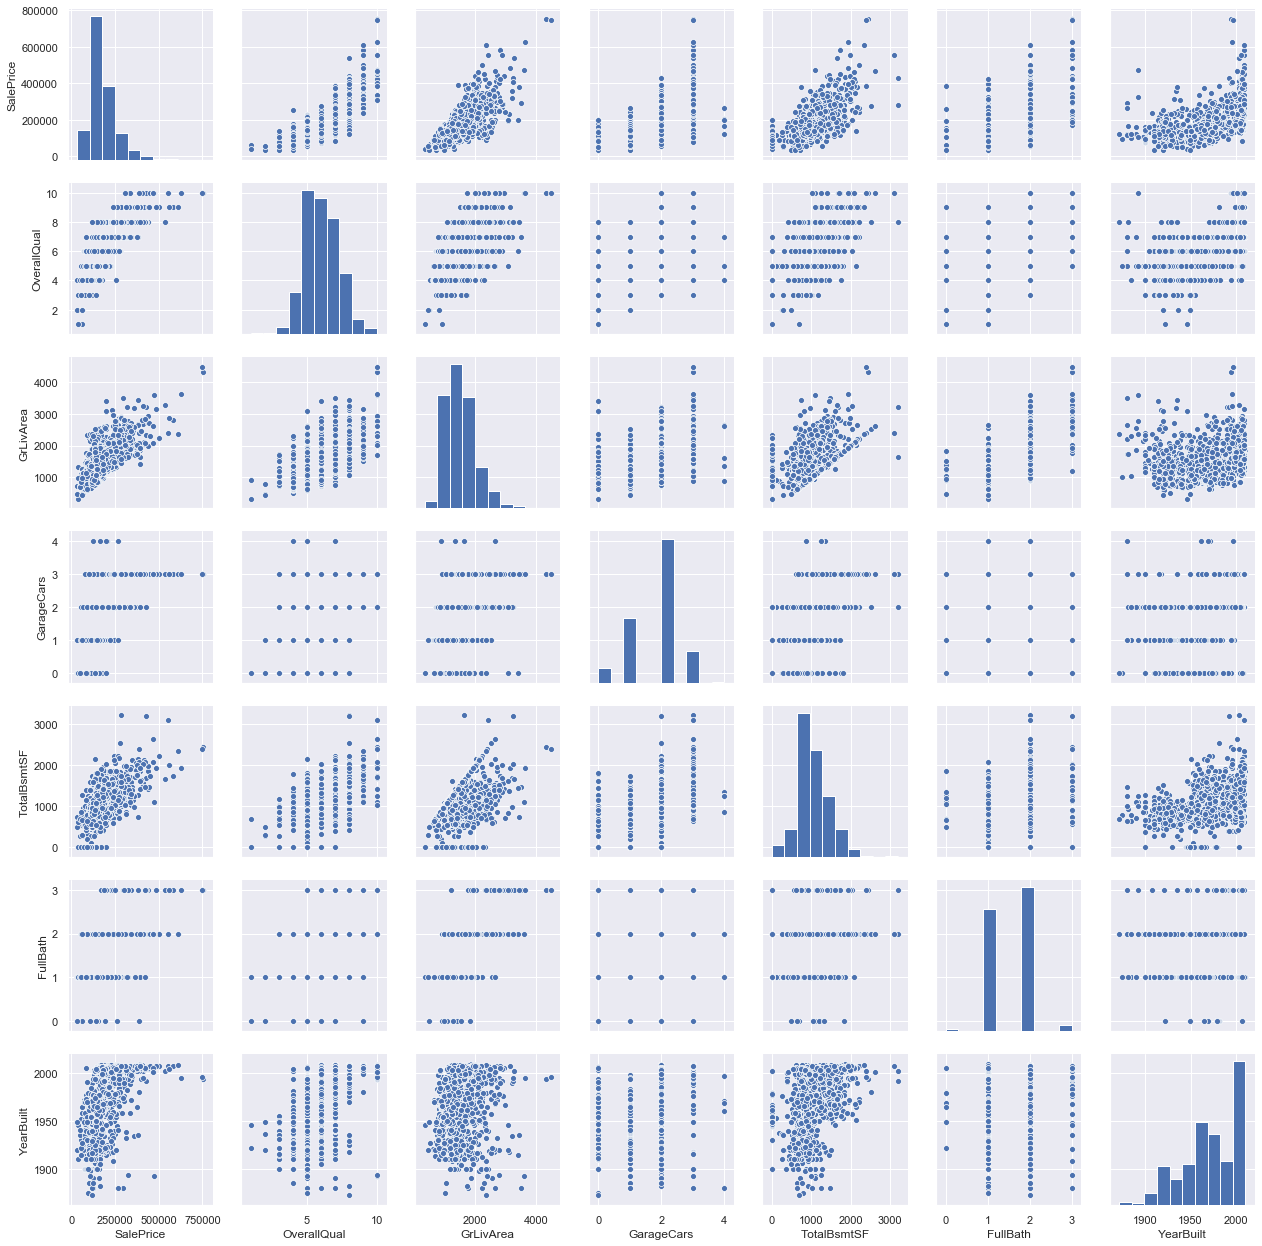

In [53]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'ExterQual', 'Foundation']
sns.pairplot(housingData_train[cols],size = 2.5)
plt.show()


In [34]:
corr = housingData_train.corr()
corr.style.background_gradient(cmap='coolwarm')

Above Scatter plot gives us a reasonable idea about some relationships
One of the figures we may find interesting is the one between 'TotalBsmtSF' and 'GrLiveArea'. In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line.

Normal Distribution

SalesPrice

In [ ]:
sns.distplot(housingData_train['SalePrice'],fit=norm)
fig = plt.figure()
res = stats.probplot(housingData_train['SalePrice'], plot=plt)

SalesPrice is not normal and shows positive skewness and does not follow the diagnol line . This can be corrected by using log transformations.

In [ ]:
#Applying log transformation
housingData_train['SalePrice'] = np.log(housingData_train['SalePrice'])

In [ ]:
#Transformed histogram and normal distribution plot
sns.distplot(housingData_train['SalePrice'],fit=norm)
fig = plt.figure()
res = stats.probplot(housingData_train['SalePrice'], plot=plt)

GrLivArea

In [ ]:
sns.distplot(housingData_train['GrLivArea'],fit=norm)
fig = plt.figure()
res = stats.probplot(housingData_train['GrLivArea'], plot=plt)

In [ ]:
#Since there is skewnes we can have them corrected using log transformation

In [ ]:
#Applying log transformation
housingData_train['GrLivArea'] = np.log(housingData_train['GrLivArea'])

In [ ]:
sns.distplot(housingData_train['GrLivArea'],fit=norm)
fig = plt.figure()
res = stats.probplot(housingData_train['GrLivArea'], plot=plt)

In [ ]:
#substitute non-quantitative data into quantitative numbers

housingData_train.loc[housingData_train['MSZoning'] == 'C (all)', 'MSZoning']= 1
housingData_train.loc[housingData_train['MSZoning'] == 'FV', 'MSZoning']= 2
housingData_train.loc[housingData_train['MSZoning'] == 'RH', 'MSZoning']= 3
housingData_train.loc[housingData_train['MSZoning'] == 'RL', 'MSZoning']= 4
housingData_train.loc[housingData_train['MSZoning'] == 'RM', 'MSZoning']= 5

housingData_train.loc[housingData_train['Street'] == 'Grvl', 'Street']= 1
housingData_train.loc[housingData_train['Street'] == 'Pave', 'Street']= 2

housingData_train.loc[housingData_train['LotShape'] == 'IR1', 'LotShape']= 1
housingData_train.loc[housingData_train['LotShape'] == 'IR2', 'LotShape']= 2
housingData_train.loc[housingData_train['LotShape'] == 'IR3', 'LotShape']= 3
housingData_train.loc[housingData_train['LotShape'] == 'Reg', 'LotShape']= 4

housingData_train.loc[housingData_train['LandContour'] == 'Bnk', 'LandContour']= 1
housingData_train.loc[housingData_train['LandContour'] == 'HLS', 'LandContour']= 2
housingData_train.loc[housingData_train['LandContour'] == 'Low', 'LandContour']= 3
housingData_train.loc[housingData_train['LandContour'] == 'Lvl', 'LandContour']= 4

housingData_train.loc[housingData_train['Utilities'] == 'AllPub', 'Utilities']= 1
housingData_train.loc[housingData_train['Utilities'] == 'NoSeWa', 'Utilities']= 2

housingData_train.loc[housingData_train['LotConfig'] == 'Corner', 'LotConfig']= 1
housingData_train.loc[housingData_train['LotConfig'] == 'CulDSac', 'LotConfig']= 2
housingData_train.loc[housingData_train['LotConfig'] == 'FR2', 'LotConfig']= 3
housingData_train.loc[housingData_train['LotConfig'] == 'FR3', 'LotConfig']= 4
housingData_train.loc[housingData_train['LotConfig'] == 'Inside', 'LotConfig']= 5


housingData_train.loc[housingData_train['LandSlope'] == 'Gtl', 'LandSlope']= 1
housingData_train.loc[housingData_train['LandSlope'] == 'Mod', 'LandSlope']= 2
housingData_train.loc[housingData_train['LandSlope'] == 'Sev', 'LandSlope']= 3

housingData_train.loc[housingData_train['Neighborhood'] == 'Blmngtn', 'Neighborhood']= 1
housingData_train.loc[housingData_train['Neighborhood'] == 'Blueste', 'Neighborhood']= 2
housingData_train.loc[housingData_train['Neighborhood'] == 'BrDale', 'Neighborhood']= 3
housingData_train.loc[housingData_train['Neighborhood'] == 'BrkSide', 'Neighborhood']= 4
housingData_train.loc[housingData_train['Neighborhood'] == 'ClearCr', 'Neighborhood']= 5
housingData_train.loc[housingData_train['Neighborhood'] == 'CollgCr', 'Neighborhood']= 6
housingData_train.loc[housingData_train['Neighborhood'] == 'Crawfor', 'Neighborhood']= 7
housingData_train.loc[housingData_train['Neighborhood'] == 'Edwards', 'Neighborhood']= 8
housingData_train.loc[housingData_train['Neighborhood'] == 'Gilbert', 'Neighborhood']= 9
housingData_train.loc[housingData_train['Neighborhood'] == 'IDOTRR', 'Neighborhood']= 10
housingData_train.loc[housingData_train['Neighborhood'] == 'MeadowV', 'Neighborhood']= 11
housingData_train.loc[housingData_train['Neighborhood'] == 'Mitchel', 'Neighborhood']= 12
housingData_train.loc[housingData_train['Neighborhood'] == 'NAmes', 'Neighborhood']= 13
housingData_train.loc[housingData_train['Neighborhood'] == 'NoRidge', 'Neighborhood']= 14
housingData_train.loc[housingData_train['Neighborhood'] == 'NPkVill', 'Neighborhood']= 15
housingData_train.loc[housingData_train['Neighborhood'] == 'NridgHt', 'Neighborhood']= 16
housingData_train.loc[housingData_train['Neighborhood'] == 'NWAmes', 'Neighborhood']= 17
housingData_train.loc[housingData_train['Neighborhood'] == 'OldTown', 'Neighborhood']= 18
housingData_train.loc[housingData_train['Neighborhood'] == 'Sawyer', 'Neighborhood']= 19
housingData_train.loc[housingData_train['Neighborhood'] == 'SawyerW', 'Neighborhood']= 20
housingData_train.loc[housingData_train['Neighborhood'] == 'Somerst', 'Neighborhood']= 21
housingData_train.loc[housingData_train['Neighborhood'] == 'StoneBr', 'Neighborhood']= 22
housingData_train.loc[housingData_train['Neighborhood'] == 'SWISU', 'Neighborhood']= 23
housingData_train.loc[housingData_train['Neighborhood'] == 'Timber', 'Neighborhood']= 24
housingData_train.loc[housingData_train['Neighborhood'] == 'Veenker', 'Neighborhood']= 25

housingData_train.loc[housingData_train['Condition1'] == 'Artery', 'Condition1']= 1
housingData_train.loc[housingData_train['Condition1'] == 'Feedr', 'Condition1']= 2
housingData_train.loc[housingData_train['Condition1'] == 'Norm', 'Condition1']= 3
housingData_train.loc[housingData_train['Condition1'] == 'PosA', 'Condition1']= 4
housingData_train.loc[housingData_train['Condition1'] == 'PosN', 'Condition1']= 5
housingData_train.loc[housingData_train['Condition1'] == 'RRAe', 'Condition1']= 6
housingData_train.loc[housingData_train['Condition1'] == 'RRAn', 'Condition1']= 7
housingData_train.loc[housingData_train['Condition1'] == 'RRNe', 'Condition1']= 8
housingData_train.loc[housingData_train['Condition1'] == 'RRNn', 'Condition1']= 9

housingData_train.loc[housingData_train['Condition2'] == 'Artery', 'Condition2']= 1
housingData_train.loc[housingData_train['Condition2'] == 'Feedr', 'Condition2']= 2
housingData_train.loc[housingData_train['Condition2'] == 'Norm', 'Condition2']= 3
housingData_train.loc[housingData_train['Condition2'] == 'PosA', 'Condition2']= 4
housingData_train.loc[housingData_train['Condition2'] == 'PosN', 'Condition2']= 5
housingData_train.loc[housingData_train['Condition2'] == 'RRAe', 'Condition2']= 6
housingData_train.loc[housingData_train['Condition2'] == 'RRAn', 'Condition2']= 7
housingData_train.loc[housingData_train['Condition2'] == 'RRNn', 'Condition2']= 8

housingData_train.loc[housingData_train['BldgType'] == '1Fam', 'BldgType']= 1
housingData_train.loc[housingData_train['BldgType'] == '2fmCon', 'BldgType']= 2
housingData_train.loc[housingData_train['BldgType'] == 'Duplex', 'BldgType']= 3
housingData_train.loc[housingData_train['BldgType'] == 'Twnhs', 'BldgType']= 4
housingData_train.loc[housingData_train['BldgType'] == 'TwnhsE', 'BldgType']= 5

housingData_train.loc[housingData_train['HouseStyle'] == '1.5Fin', 'HouseStyle']= 1
housingData_train.loc[housingData_train['HouseStyle'] == '1.5Unf', 'HouseStyle']= 2
housingData_train.loc[housingData_train['HouseStyle'] == '1Story', 'HouseStyle']= 3
housingData_train.loc[housingData_train['HouseStyle'] == '2.5Fin', 'HouseStyle']= 4
housingData_train.loc[housingData_train['HouseStyle'] == '2.5Unf', 'HouseStyle']= 5
housingData_train.loc[housingData_train['HouseStyle'] == '2Story', 'HouseStyle']= 6
housingData_train.loc[housingData_train['HouseStyle'] == 'SFoyer', 'HouseStyle']= 7
housingData_train.loc[housingData_train['HouseStyle'] == 'SLvl', 'HouseStyle']= 8

housingData_train.loc[housingData_train['RoofStyle'] == 'Flat', 'RoofStyle']= 1
housingData_train.loc[housingData_train['RoofStyle'] == 'Gable', 'RoofStyle']= 2
housingData_train.loc[housingData_train['RoofStyle'] == 'Gambrel', 'RoofStyle']= 3
housingData_train.loc[housingData_train['RoofStyle'] == 'Hip', 'RoofStyle']= 4
housingData_train.loc[housingData_train['RoofStyle'] == 'Mansard', 'RoofStyle']= 5
housingData_train.loc[housingData_train['RoofStyle'] == 'Shed', 'RoofStyle']= 6

housingData_train.loc[housingData_train['RoofMatl'] == 'ClyTile', 'RoofMatl']= 1
housingData_train.loc[housingData_train['RoofMatl'] == 'CompShg', 'RoofMatl']= 2
housingData_train.loc[housingData_train['RoofMatl'] == 'Membran', 'RoofMatl']= 3
housingData_train.loc[housingData_train['RoofMatl'] == 'Metal', 'RoofMatl']= 4
housingData_train.loc[housingData_train['RoofMatl'] == 'Roll', 'RoofMatl']= 5
housingData_train.loc[housingData_train['RoofMatl'] == 'Tar&Grv', 'RoofMatl']= 6
housingData_train.loc[housingData_train['RoofMatl'] == 'WdShake', 'RoofMatl']= 7
housingData_train.loc[housingData_train['RoofMatl'] == 'WdShngl', 'RoofMatl']= 8

housingData_train.loc[housingData_train['Exterior1st'] == 'AsbShng', 'Exterior1st']= 1
housingData_train.loc[housingData_train['Exterior1st'] == 'AsphShn', 'Exterior1st']= 2
housingData_train.loc[housingData_train['Exterior1st'] == 'BrkComm', 'Exterior1st']= 3
housingData_train.loc[housingData_train['Exterior1st'] == 'BrkFace', 'Exterior1st']= 4
housingData_train.loc[housingData_train['Exterior1st'] == 'CBlock', 'Exterior1st']= 5
housingData_train.loc[housingData_train['Exterior1st'] == 'CemntBd', 'Exterior1st']= 6
housingData_train.loc[housingData_train['Exterior1st'] == 'HdBoard', 'Exterior1st']= 7
housingData_train.loc[housingData_train['Exterior1st'] == 'ImStucc', 'Exterior1st']= 8
housingData_train.loc[housingData_train['Exterior1st'] == 'MetalSd', 'Exterior1st']= 9
housingData_train.loc[housingData_train['Exterior1st'] == 'Plywood', 'Exterior1st']= 10
housingData_train.loc[housingData_train['Exterior1st'] == 'Stone', 'Exterior1st']= 11
housingData_train.loc[housingData_train['Exterior1st'] == 'Stucco', 'Exterior1st']= 12
housingData_train.loc[housingData_train['Exterior1st'] == 'VinylSd', 'Exterior1st']= 13
housingData_train.loc[housingData_train['Exterior1st'] == 'Wd Sdng', 'Exterior1st']= 14
housingData_train.loc[housingData_train['Exterior1st'] == 'WdShing', 'Exterior1st']= 15

housingData_train.loc[housingData_train['Exterior2nd'] == 'AsbShng', 'Exterior2nd']= 1
housingData_train.loc[housingData_train['Exterior2nd'] == 'AsphShn', 'Exterior2nd']= 2
housingData_train.loc[housingData_train['Exterior2nd'] == 'Brk Cmn', 'Exterior2nd']= 3
housingData_train.loc[housingData_train['Exterior2nd'] == 'BrkFace', 'Exterior2nd']= 4
housingData_train.loc[housingData_train['Exterior2nd'] == 'CBlock', 'Exterior2nd']= 5
housingData_train.loc[housingData_train['Exterior2nd'] == 'CmentBd', 'Exterior2nd']= 6
housingData_train.loc[housingData_train['Exterior2nd'] == 'HdBoard', 'Exterior2nd']= 7
housingData_train.loc[housingData_train['Exterior2nd'] == 'ImStucc', 'Exterior2nd']= 8
housingData_train.loc[housingData_train['Exterior2nd'] == 'MetalSd', 'Exterior2nd']= 9
housingData_train.loc[housingData_train['Exterior2nd'] == 'Other', 'Exterior2nd']= 10
housingData_train.loc[housingData_train['Exterior2nd'] == 'Plywood', 'Exterior2nd']= 11
housingData_train.loc[housingData_train['Exterior2nd'] == 'Stone', 'Exterior2nd']= 12
housingData_train.loc[housingData_train['Exterior2nd'] == 'Stucco', 'Exterior2nd']= 13
housingData_train.loc[housingData_train['Exterior2nd'] == 'VinylSd', 'Exterior2nd']= 14
housingData_train.loc[housingData_train['Exterior2nd'] == 'Wd Sdng', 'Exterior2nd']= 15
housingData_train.loc[housingData_train['Exterior2nd'] == 'Wd Shng', 'Exterior2nd']= 16

housingData_train.loc[housingData_train['ExterQual'] == 'Ex', 'ExterQual']= 1
housingData_train.loc[housingData_train['ExterQual'] == 'Fa', 'ExterQual']= 2
housingData_train.loc[housingData_train['ExterQual'] == 'Gd', 'ExterQual']= 3
housingData_train.loc[housingData_train['ExterQual'] == 'TA', 'ExterQual']= 4

housingData_train.loc[housingData_train['ExterCond'] == 'Ex', 'ExterCond']= 1
housingData_train.loc[housingData_train['ExterCond'] == 'Fa', 'ExterCond']= 2
housingData_train.loc[housingData_train['ExterCond'] == 'Gd', 'ExterCond']= 3
housingData_train.loc[housingData_train['ExterCond'] == 'TA', 'ExterCond']= 4
housingData_train.loc[housingData_train['ExterCond'] == 'Po', 'ExterCond']= 5

housingData_train.loc[housingData_train['Foundation'] == 'BrkTil', 'Foundation']= 1
housingData_train.loc[housingData_train['Foundation'] == 'CBlock', 'Foundation']= 2
housingData_train.loc[housingData_train['Foundation'] == 'PConc', 'Foundation']= 3
housingData_train.loc[housingData_train['Foundation'] == 'Slab', 'Foundation']= 4
housingData_train.loc[housingData_train['Foundation'] == 'Stone', 'Foundation']= 5
housingData_train.loc[housingData_train['Foundation'] == 'Wood', 'Foundation']= 6

housingData_train.loc[housingData_train['Heating'] == 'Floor', 'Heating']= 1
housingData_train.loc[housingData_train['Heating'] == 'GasA', 'Heating']= 2
housingData_train.loc[housingData_train['Heating'] == 'GasW', 'Heating']= 3
housingData_train.loc[housingData_train['Heating'] == 'Grav', 'Heating']= 4
housingData_train.loc[housingData_train['Heating'] == 'OthW', 'Heating']= 5
housingData_train.loc[housingData_train['Heating'] == 'Wall', 'Heating']= 6

housingData_train.loc[housingData_train['HeatingQC'] == 'Ex', 'HeatingQC']= 1
housingData_train.loc[housingData_train['HeatingQC'] == 'Fa', 'HeatingQC']= 2
housingData_train.loc[housingData_train['HeatingQC'] == 'Gd', 'HeatingQC']= 3
housingData_train.loc[housingData_train['HeatingQC'] == 'Po', 'HeatingQC']= 4
housingData_train.loc[housingData_train['HeatingQC'] == 'TA', 'HeatingQC']= 5

housingData_train.loc[housingData_train['Electrical'] == 'NA', 'Electrical']= 0
housingData_train.loc[housingData_train['Electrical'] == 'FuseA', 'Electrical']= 1
housingData_train.loc[housingData_train['Electrical'] == 'FuseF', 'Electrical']= 2
housingData_train.loc[housingData_train['Electrical'] == 'FuseP', 'Electrical']= 3
housingData_train.loc[housingData_train['Electrical'] == 'Mix', 'Electrical']= 4
housingData_train.loc[housingData_train['Electrical'] == 'SBrKr', 'Electrical']= 5

housingData_train.loc[housingData_train['KitchenQual'] == 'Ex', 'KitchenQual']= 1
housingData_train.loc[housingData_train['KitchenQual'] == 'Fa', 'KitchenQual']= 2
housingData_train.loc[housingData_train['KitchenQual'] == 'Gd', 'KitchenQual']= 3
housingData_train.loc[housingData_train['KitchenQual'] == 'TA', 'KitchenQual']= 4

housingData_train.loc[housingData_train['Functional'] == 'Maj1', 'Functional']= 1
housingData_train.loc[housingData_train['Functional'] == 'Maj2', 'Functional']= 2
housingData_train.loc[housingData_train['Functional'] == 'Min1', 'Functional']= 3
housingData_train.loc[housingData_train['Functional'] == 'Min2', 'Functional']= 4
housingData_train.loc[housingData_train['Functional'] == 'Mod', 'Functional']= 5
housingData_train.loc[housingData_train['Functional'] == 'Sev', 'Functional']= 6
housingData_train.loc[housingData_train['Functional'] == 'Typ', 'Functional']= 7

housingData_train.loc[housingData_train['GarageType'] == 'NA', 'GarageType']= 0
housingData_train.loc[housingData_train['GarageType'] == '2Type', 'GarageType']= 1
housingData_train.loc[housingData_train['GarageType'] == 'Attachd', 'GarageType']= 2
housingData_train.loc[housingData_train['GarageType'] == 'Basement', 'GarageType']= 3
housingData_train.loc[housingData_train['GarageType'] == 'BuiltIn', 'GarageType']= 4
housingData_train.loc[housingData_train['GarageType'] == 'CarPort', 'GarageType']= 5
housingData_train.loc[housingData_train['GarageType'] == 'Detchd', 'GarageType']= 6

housingData_train.loc[housingData_train['GarageFinish'] == 'NA', 'GarageFinish']= 0
housingData_train.loc[housingData_train['GarageFinish'] == 'Fin', 'GarageFinish']= 1
housingData_train.loc[housingData_train['GarageFinish'] == 'RFn', 'GarageFinish']= 2
housingData_train.loc[housingData_train['GarageFinish'] == 'Unf', 'GarageFinish']= 3

housingData_train.loc[housingData_train['GarageQual'] == 'NA', 'GarageQual']= 0
housingData_train.loc[housingData_train['GarageQual'] == 'Gd', 'GarageQual']= 1
housingData_train.loc[housingData_train['GarageQual'] == 'Po', 'GarageQual']= 2
housingData_train.loc[housingData_train['GarageQual'] == 'TA', 'GarageQual']= 3
housingData_train.loc[housingData_train['GarageQual'] == 'Ex', 'GarageQual']= 4
housingData_train.loc[housingData_train['GarageQual'] == 'Fa', 'GarageQual']= 5

housingData_train.loc[housingData_train['GarageCond'] == 'NA', 'GarageCond']= 0
housingData_train.loc[housingData_train['GarageCond'] == 'Gd', 'GarageCond']= 1
housingData_train.loc[housingData_train['GarageCond'] == 'Po', 'GarageCond']= 2
housingData_train.loc[housingData_train['GarageCond'] == 'TA', 'GarageCond']= 3
housingData_train.loc[housingData_train['GarageCond'] == 'Ex', 'GarageCond']= 4
housingData_train.loc[housingData_train['GarageCond'] == 'Fa', 'GarageCond']= 5

housingData_train.loc[housingData_train['PavedDrive'] == 'N', 'PavedDrive']= 0
housingData_train.loc[housingData_train['PavedDrive'] == 'Y', 'PavedDrive']= 1

housingData_train.loc[housingData_train['PoolQC'] == 'NA', 'PoolQC']= 0
housingData_train.loc[housingData_train['PoolQC'] == 'Ex', 'PoolQC']= 1
housingData_train.loc[housingData_train['PoolQC'] == 'Fa', 'PoolQC']= 2
housingData_train.loc[housingData_train['PoolQC'] == 'Gd', 'PoolQC']= 3

housingData_train.loc[housingData_train['SaleCondition'] == 'Abnorml', 'SaleCondition']= 1
housingData_train.loc[housingData_train['SaleCondition'] == 'AbjLand', 'SaleCondition']= 2
housingData_train.loc[housingData_train['SaleCondition'] == 'Alloca', 'SaleCondition']= 3
housingData_train.loc[housingData_train['SaleCondition'] == 'Family', 'SaleCondition']= 4
housingData_train.loc[housingData_train['SaleCondition'] == 'Normal', 'SaleCondition']= 5
housingData_train.loc[housingData_train['SaleCondition'] == 'Partial', 'SaleCondition']= 6

housingData_train.loc[housingData_train['SaleType'] == 'COD', 'SaleType']= 1
housingData_train.loc[housingData_train['SaleType'] == 'Con', 'SaleType']= 2
housingData_train.loc[housingData_train['SaleType'] == 'ConLD', 'SaleType']= 3
housingData_train.loc[housingData_train['SaleType'] == 'ConLw', 'SaleType']= 4
housingData_train.loc[housingData_train['SaleType'] == 'CWD', 'SaleType']= 5
housingData_train.loc[housingData_train['SaleType'] == 'New', 'SaleType']= 6
housingData_train.loc[housingData_train['SaleType'] == 'Oth', 'SaleType']= 7
housingData_train.loc[housingData_train['SaleType'] == 'WD', 'SaleType']= 8

housingData_train.loc[housingData_train['MiscFeature'] == 'NA', 'MiscFeature']= 0
housingData_train.loc[housingData_train['MiscFeature'] == 'Othr', 'MiscFeature']= 1
housingData_train.loc[housingData_train['MiscFeature'] == 'Shed', 'MiscFeature']= 2
housingData_train.loc[housingData_train['MiscFeature'] == 'Tenc', 'MiscFeature']= 3

housingData_train.loc[housingData_train['Fence'] == 'NA', 'Fence']= 0
housingData_train.loc[housingData_train['Fence'] == 'GdPrv', 'Fence']= 1
housingData_train.loc[housingData_train['Fence'] == 'GdWo', 'Fence']= 2
housingData_train.loc[housingData_train['Fence'] == 'MnPrv', 'Fence']= 3
housingData_train.loc[housingData_train['Fence'] == 'MnWw', 'Fence']= 4




In [60]:
# Apply regression model with above column 
reg = linear_model.LinearRegression()
print(reg)

x = housingData_train[['OverallQual', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 
                       'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']].copy(deep=True)
y = housingData_train[['SalePrice']].copy(deep=True)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)
reg.fit(x_train, y_train)
print(reg.coef_)
# r-squared for the test data
reg.score(x_test, y_test)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
[[ 1.91117835e+04  3.54248270e+02  3.41756372e+01  9.15091053e+00
   6.28061288e+01 -7.73611221e+03 -9.63185628e+02  2.22585688e+03
   3.63887038e+01]]


0.8293103290791051

In [61]:
# Applied Lasso Model


lassoReg = Lasso(alpha=10, normalize=False)

lassoReg.fit(x_train,y_train)

pred = lassoReg.predict(x_test)
print(pred.shape, y_test.shape)

# calculating mse

mse = np.mean((pred - np.array(y_test).flatten())**2)
print(mse)

b = lassoReg.score(x_test,y_test) 

# returns the r-squared value
print(b)

(292,) (292, 1)
1238653320.8863127
0.829267322269208


In [ ]:
# Linear regression (0.8293) has better R square value.

In [64]:
#Test Linear regression with test data

#house[['OverallQual', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']].copy(deep=True)
test1 = [[5, 1961, 882, 896, 896, 1, 5, 1, 730]]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)
reg.fit(x_train, y_train)
print(reg.coef_)
print(reg.score(x_test, y_test))

pred2 = reg.predict(test1)
print(pred2)

[[ 1.91117835e+04  3.54248270e+02  3.41756372e+01  9.15091053e+00
   6.28061288e+01 -7.73611221e+03 -9.63185628e+02  2.22585688e+03
   3.63887038e+01]]
0.8293103290791051
[[123220.89038923]]


In [65]:
# House price $123,220 is predicted